In [9]:
# %pip install pyvista
import time
import torch
import pyvista as pv
import matplotlib.pyplot as plt
import yaml
import numpy as np
from typing import OrderedDict

In [10]:
from mymodel import init_my_model


def load_data(dataset_path):
    """
    Load dataset from a given path of the format .pt
    It has two tensors: input data and label data

    :param dataset_path: Path to the dataset file
    :return: Loaded dataset
    """
    print(f"Loading dataset from {dataset_path}")
    # Use safe globals to allow loading TensorDataset
    with torch.serialization.safe_globals([torch.utils.data.dataset.TensorDataset]):
        dataset = torch.load(dataset_path)
        print(
            f"shape of loaded dataset: Input: {dataset.tensors[0].shape} and labels: {dataset.tensors[1].shape}"
        )
    return dataset


def train_model(model, optimizer, criterion, device, epochs, train_loader, val_loader):
    """
    Train the model

    :param model: Model to be trained
    :param optimizer: Optimizer for training
    :param criterion: Loss function
    :param device: Device to run the training on
    :param epochs: Number of epochs to train
    :return: train_losses, val_losses
    """
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        val_loss = 0.0

        for batch_input, batch_label in train_loader:
            inputs, labels = batch_input.to(device), batch_label.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        running_loss /= len(train_loader.dataset)

        model.eval()
        with torch.no_grad():
            for val_input, val_label in val_loader:
                val_inputs, val_labels = val_input.to(device), val_label.to(device)
                y_val_pred = model(val_inputs)
                val_loss += criterion(y_val_pred, val_labels)*val_input.size(0) 
        val_loss /= len(val_loader.dataset)

        train_losses.append(running_loss)
        val_losses.append(val_loss.item())

        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs:4d} | Train Loss: {running_loss:.4e} | Test Loss: {val_loss:.4e}")

    print("Training completed!")
    return train_losses, val_losses


def save_params(model, filepath):
    """
    Save the params of the model to a given filepath

    :param model: Model to be saved
    :param filepath: Path to save the model
    """
    print(f"Saving model to {filepath}")
    torch.save(model.state_dict(), filepath)


def load_params(model, filepath):
    """
    Load the params of the model from a given filepath

    :param model: Model to load the params into
    :param filepath: Path to load the model from
    """
    print(f"Loading params from {filepath}")
    model.load_state_dict(torch.load(filepath))
    return model


def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.semilogy(train_losses, label="Train Loss")
    plt.semilogy(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss MSE")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.show()


def evaluate_model(model, criterion, device, test_dataset):
    model.eval()
    with torch.no_grad():
        y_pred_all = model(test_dataset.tensors[0].to(device))
        #test_loss = criterion(y_pred_all, test_dataset.tensors[1]).item()
        test_loss = criterion(y_pred_all, test_dataset.tensors[1].to(device)).item()

    print(f"Test Loss: {test_loss}")
    return test_loss, y_pred_all


def plot_test_results(test_dataset, y_pred_all, num_samples: int = 3):
    test_inputs = test_dataset.tensors[0].cpu()
    test_labels = test_dataset.tensors[1].cpu()
    test_outputs = y_pred_all.cpu()

    for i in range(num_samples):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title("Input")
        plt.imshow(test_inputs[i, 0, :, :], cmap="viridis")
        plt.colorbar()

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(test_labels[i, 0, :, :], cmap="viridis")
        plt.colorbar()

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(test_outputs[i, 0, :, :], cmap="viridis")
        plt.colorbar()

        plt.show()


def generate_data(folder_path, velocities_range, num_samples):
    input_all = []
    label_all = []
    velocities = np.linspace(
        velocities_range[0], velocities_range[1], num=num_samples
    )

    # Read all files
    for i in range(num_samples):
        #grid = pv.read(f"{folder_path}output_{i}.vti")
        grid = pv.read(f"{folder_path}output_{str(i).zfill(4)}.vti")

        u = np.array(grid.point_data["velocity"][:, 0])  # u component
        v = np.array(grid.point_data["velocity"][:, 1])  # v component

        dims = grid.dimensions  # (nx, ny, nz) (21, 21, 1)
        u = u.reshape(dims)
        v = v.reshape(dims)

        uv_combined = np.concatenate([u, v], axis=-1)  # (21, 21, 2)

        input = np.zeros(dims)
        input[-1, 1:dims[1] - 1, 0] = velocities[i]  # (21, 21, 1)

        input_all.append(input)
        label_all.append(uv_combined)

    input_all = np.array(input_all)
    input_all = np.transpose(input_all, (0, 3, 1, 2))  # Now shape is (num_files, channels=1, ny, nx)
    label_all = np.array(label_all)
    label_all = np.transpose(label_all, (0, 3, 1, 2))  # Now shape is (num_files, channels=2, ny, nx)

    print(f"Generated {len(label_all)} samples of data.")
    print(f"Each sample has shape: {label_all[0].shape} for labels and {input_all[0].shape} for inputs.")
    print(f"Label data shape: {label_all.shape}")
    print(f"Input data shape: {input_all.shape}")

    return label_all, input_all


def plot_sample_data(label_all, input_all, sample_index):
    sample = label_all[sample_index]  # shape (channels=2, ny, nx)
    sample_input = input_all[sample_index]  # shape (channels=1, ny, nx)
    u_component = sample[0, :, :]
    v_component = sample[1, :, :]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 3, 1)
    plt.title("U Component")
    plt.imshow(u_component, cmap="viridis")
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("V Component")
    plt.imshow(v_component, cmap="viridis")
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Input U Component")
    plt.imshow(sample_input[0, :, :], cmap="viridis")
    plt.colorbar()

    plt.show()


def normalize_data(label_data, input_data, yaml_filepath):
    u_min = label_data[:, 0, :, :].min()
    u_max = label_data[:, 0, :, :].max()
    v_min = label_data[:, 1, :, :].min()
    v_max = label_data[:, 1, :, :].max()
    u_input_min = input_data[:, 0, :, :].min()
    u_input_max = input_data[:, 0, :, :].max()
    print(f"Input U component original range: [{u_input_min}, {u_input_max}]")
    print(f"U component original range: [{u_min}, {u_max}]")
    print(f"V component original range: [{v_min}, {v_max}]")

    # scale labels:
    data_scaled = np.empty_like(label_data)
    data_scaled[:, 0, :, :] = (label_data[:, 0, :, :] - u_min) / (u_max - u_min)
    data_scaled[:, 1, :, :] = (label_data[:, 1, :, :] - v_min) / (v_max - v_min)

    print(
        f"U component scaled to range: [{data_scaled[:,0,:,:].min()}, {data_scaled[:,0,:,:].max()}]"
    )
    print(
        f"V component scaled to range: [{data_scaled[:,1,:,:].min()}, {data_scaled[:,1,:,:].max()}]"
    )

    # scale inputs:
    input_scaled = np.empty_like(input_data)
    input_scaled[:, 0, :, :] = (input_data[:, 0, :, :] - u_input_min) / (
        u_input_max - u_input_min
    )

    generateYAML(u_min, u_max, v_min, v_max, u_input_min, u_input_max, yaml_filepath)

    return data_scaled, input_scaled

def unnormalize_data(label_scaled, yaml_filepath):
    with open(yaml_filepath, "r") as f:
        min_max = yaml.safe_load(f)

    u_min = min_max["labels"]["u"]["min"]
    u_max = min_max["labels"]["u"]["max"]
    v_min = min_max["labels"]["v"]["min"]
    v_max = min_max["labels"]["v"]["max"]

    data_unnormalized = np.empty_like(label_scaled)
    data_unnormalized[:, 0, :, :] = label_scaled[:, 0, :, :] * (u_max - u_min) + u_min
    data_unnormalized[:, 1, :, :] = label_scaled[:, 1, :, :] * (v_max - v_min) + v_min

    return data_unnormalized


def split_and_save(label_scaled, input_scaled, train_ratio, test_ratio, save_path):
    data = torch.utils.data.TensorDataset(
        torch.FloatTensor(input_scaled),
        torch.FloatTensor(label_scaled)
    )
    num = len(data)
    train_count = int(num * train_ratio)
    test_count = int(num * test_ratio)
    val_count = num - train_count - test_count
    print(f"Splitting data into Train: {train_count}, Test: {test_count}, Validation: {val_count}")

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        data,
        [train_count, val_count, test_count]
    )
    # convert Subset to TensorDataset for saving
    train_dataset = torch.utils.data.TensorDataset(
        train_dataset.dataset.tensors[0][train_dataset.indices],
        train_dataset.dataset.tensors[1][train_dataset.indices],
    )
    test_dataset = torch.utils.data.TensorDataset(
        test_dataset.dataset.tensors[0][test_dataset.indices],
        test_dataset.dataset.tensors[1][test_dataset.indices],
    )
    val_dataset = torch.utils.data.TensorDataset(
        val_dataset.dataset.tensors[0][val_dataset.indices],
        val_dataset.dataset.tensors[1][val_dataset.indices],
    )

    torch.save(train_dataset, save_path + "train_dataset.pt")
    torch.save(test_dataset, save_path + "test_dataset.pt")
    torch.save(val_dataset, save_path + "validation_dataset.pt")
    print(f"Datasets saved to {save_path}")


def generateYAML(u_min, u_max, v_min, v_max, input_min, input_max, yaml_filepath):
    min_max = {
        "inputs": {"u": {"max": float(input_max), "min": float(input_min)}},
        "labels": {
            "u": {"max": float(u_max), "min": float(u_min)},
            "v": {"max": float(v_max), "min": float(v_min)},
        },
    }

    # Save to yaml file
    print(f"Saving min_max.yaml to {yaml_filepath}")
    with open(yaml_filepath, "w") as f:
        yaml.dump(min_max, f, default_flow_style=False)

    print("min_max.yaml file created successfully!")
    print("\nContents:")
    print(yaml.dump(min_max, default_flow_style=False))

Generated 101 samples of data.
Each sample has shape: (2, 21, 21) for labels and (1, 21, 21) for inputs.
Label data shape: (101, 2, 21, 21)
Input data shape: (101, 1, 21, 21)


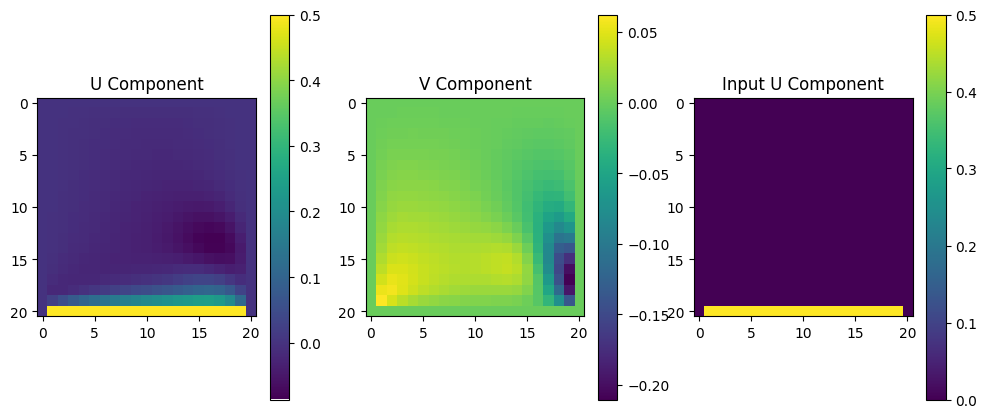

Input U component original range: [0.0, 1.5]
U component original range: [-0.25587589567699415, 1.5000002831997326]
V component original range: [-0.3722223503811245, 0.20091928070534526]
U component scaled to range: [0.0, 1.0]
V component scaled to range: [0.0, 1.0]
Saving min_max.yaml to ./out_ml/min_max.yaml
min_max.yaml file created successfully!

Contents:
inputs:
  u:
    max: 1.5
    min: 0.0
labels:
  u:
    max: 1.5000002831997326
    min: -0.25587589567699415
  v:
    max: 0.20091928070534526
    min: -0.3722223503811245

Splitting data into Train: 80, Test: 10, Validation: 11
Datasets saved to ./out_ml/


In [11]:
velocity_range = (0.5, 1.5)
num_samples = 101
train_ratio = 0.8
test_ratio = 0.1
in_data_dir = "../out/"
# in_data_dir = "/kaggle/input/101-lid-driven-cavities/"
out_pre = "./out_ml/"
# out_pre = "/kaggle/working/"

label_all, input_all = generate_data(in_data_dir, velocities_range=velocity_range, num_samples=num_samples)
plot_sample_data(label_all, input_all, sample_index=0)
label_scaled, input_scaled = normalize_data(label_all, input_all, f"{out_pre}min_max.yaml")
data = torch.utils.data.TensorDataset(
        torch.FloatTensor(input_scaled),
        torch.FloatTensor(label_scaled)
    )
split_and_save(label_scaled, input_scaled, train_ratio=train_ratio, test_ratio=test_ratio, save_path=f"{out_pre}")


Sequential(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (conv3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (conv4): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu4): ReLU()
  (conv5): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu5): ReLU()
  (conv6): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu6): ReLU()
  (conv7): Conv2d(16, 2, kernel_size=(7, 7), stride=(1, 1), padding=same)
)
running on device cpu
Loading dataset from ./out_ml/train_dataset.pt
shape of loaded dataset: Input: torch.Size([80, 1, 21, 21]) and labels: torch.Size([80, 2, 21, 21])
min, max of training inputs and labels: 0.0, 1.0, 0.0, 1.0
Loading dataset from ./out_ml/test_dataset.pt
shape of loaded dataset: Input: torch.Size([10, 1, 21, 21]) and labels: torch.Siz

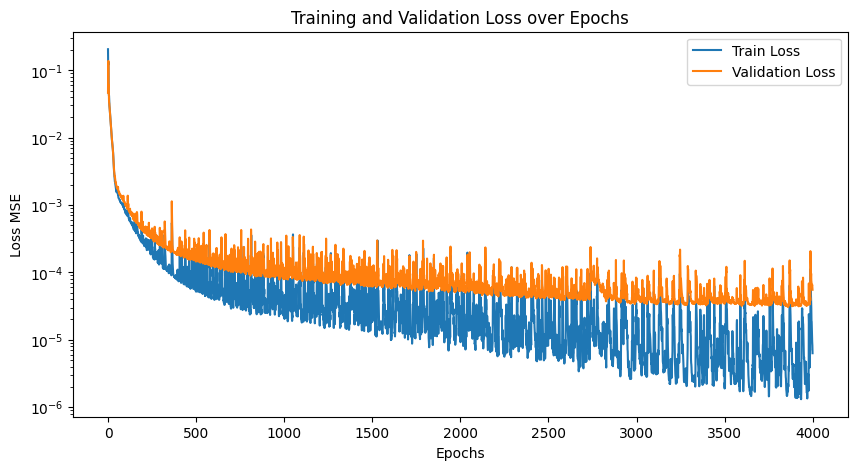

In [12]:
epochs = 4000
lr = 1e-3
batch_size = 16

mymodel = init_my_model(activation_function = torch.nn.ReLU())
print(mymodel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"running on device {device}")
mymodel.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(mymodel.parameters(), lr)  # WWWWWWWWWWWWWWWWWWWWWWWWWW
train_dataset = load_data(f"{out_pre}train_dataset.pt")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True  # SHUFFLE SHUFFLE SHUFFLE
)
print(f"min, max of training inputs and labels: {train_dataset.tensors[0].min()}, {train_dataset.tensors[0].max()}, {train_dataset.tensors[1].min()}, {train_dataset.tensors[1].max()}")
test_dataset = load_data(f"{out_pre}test_dataset.pt")
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False  # SHUFFLE SHUFFLE SHUFFLE
)
print(f"min, max of test inputs and labels: {test_dataset.tensors[0].min()}, {test_dataset.tensors[0].max()}, {test_dataset.tensors[1].min()}, {test_dataset.tensors[1].max()}")
val_dataset = load_data(f"{out_pre}validation_dataset.pt")
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False  # SHUFFLE SHUFFLE SHUFFLE
)
print(f"min, max of val inputs and labels: {val_dataset.tensors[0].min()}, {val_dataset.tensors[0].max()}, {val_dataset.tensors[1].min()}, {val_dataset.tensors[1].max()}")

start = time.time()
train_losses, val_losses = train_model(
    mymodel, optimizer, criterion, device, epochs, train_loader, val_loader
)
print(f"Training time: {time.time() - start} seconds")
np.save(f"{out_pre}train_losses.npy", np.array(train_losses))
np.save(f"{out_pre}val_losses.npy", np.array(val_losses))
save_params(mymodel, f"{out_pre}model.pt")
plot_loss(train_losses, val_losses)

Test Loss: 1.0368672519689426e-05
Test Loss: 1.2684497960435692e-05


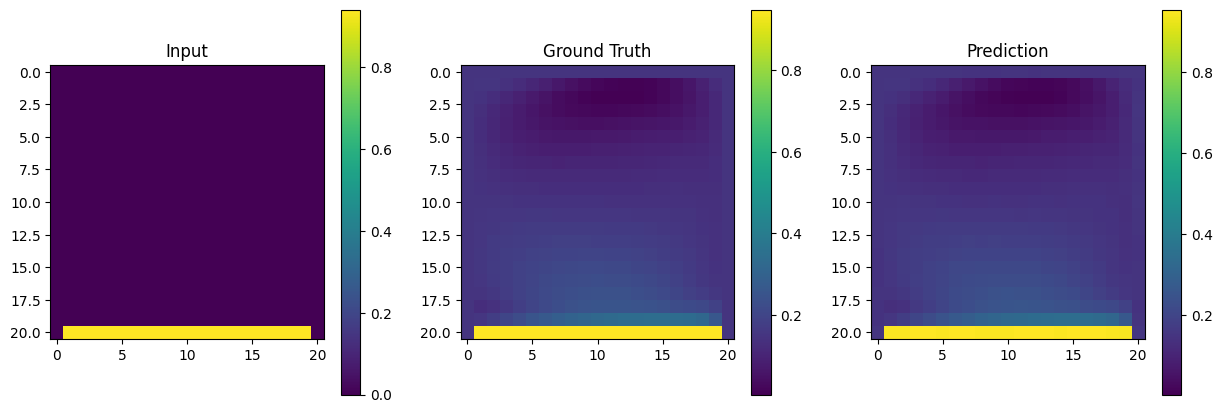

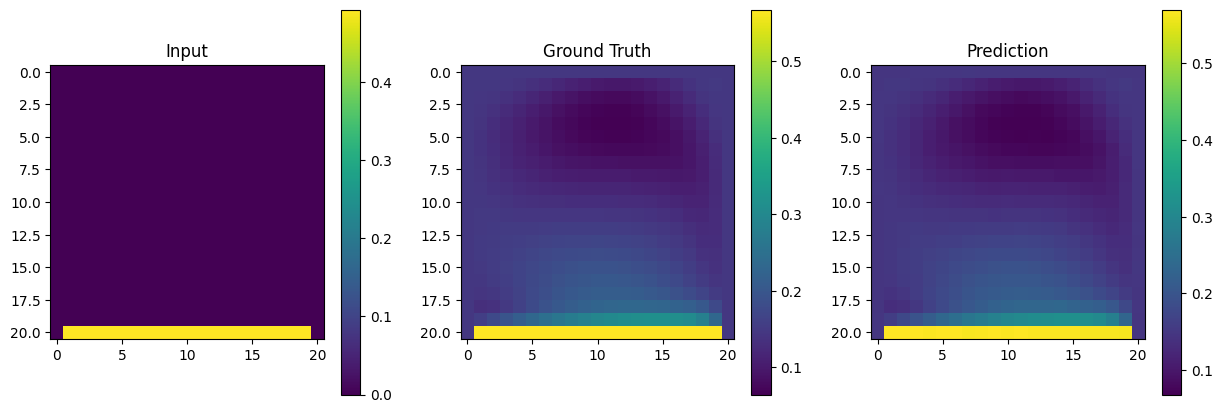

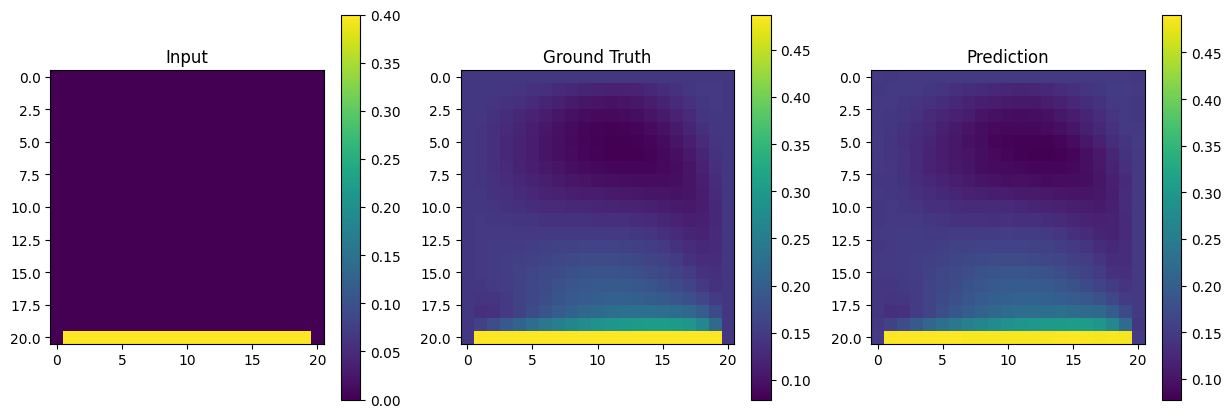

In [13]:
test_loss, y_pred_all = evaluate_model(mymodel, criterion, device, test_dataset)
test_loss2, y_pred_all2 = evaluate_model(mymodel, criterion, device, data)
plot_test_results(test_dataset, y_pred_all, num_samples=3)
np.save(f"{out_pre}train_losses.npy", np.array(train_losses))
np.save(f"{out_pre}val_losses.npy", np.array(val_losses))